# Movie Recommendation System
## Using Content-Based and Collaborative Filtering

**Author:** M B GIRISH  
**Email:** mbgirish2004@gmail.com  
**Date:** 2025  
**Dataset:** MovieLens Latest Small Dataset

---

## Table of Contents
1. [Project Introduction](#1-project-introduction)
2. [Import Libraries & Load Data](#2-import-libraries--load-data)
3. [Data Understanding & EDA](#3-data-understanding--eda)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Content-Based Recommendation System](#5-content-based-recommendation-system)
6. [Collaborative Filtering Recommendation System](#6-collaborative-filtering-recommendation-system)
7. [Model Evaluation](#7-model-evaluation)
8. [Comparison of Approaches](#8-comparison-of-approaches)
9. [Business Insights](#9-business-insights)
10. [Conclusion](#10-conclusion)


## 1. Project Introduction

### What are Recommendation Systems?

Recommendation systems are information filtering systems that predict the "rating" or "preference" a user would give to an item. They are widely used in various industries to help users discover products, content, or services they might be interested in.

### Business Importance

**User Engagement:** Recommendation systems significantly increase user engagement by helping users discover relevant content quickly, reducing the time spent searching.

**Retention:** Personalized recommendations improve user satisfaction, leading to higher retention rates and reduced churn.

**Personalization:** By understanding user preferences, companies can deliver tailored experiences that increase conversion rates and customer lifetime value.

**Revenue Impact:** Companies like Netflix report that 80% of content watched comes from recommendations, directly impacting revenue.

### Problem Statement

In this project, we aim to build a comprehensive movie recommendation system that:
- Recommends movies to users based on their viewing history and preferences
- Uses both content-based filtering (movie features) and collaborative filtering (user behavior)
- Provides accurate, personalized recommendations to improve user experience
- Can be evaluated and deployed in a production environment

### Approach

We will implement two main approaches:
1. **Content-Based Filtering:** Recommends movies similar to those a user has liked, based on movie features (genres)
2. **Collaborative Filtering:** Recommends movies based on preferences of similar users using matrix factorization techniques


## 2. Import Libraries & Load Data


In [1]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the datasets
# IMPORTANT: Update the data_path to point to your dataset location
# Download the MovieLens dataset from: https://grouplens.org/datasets/movielens/latest/
# Extract movies.csv and ratings.csv to a directory and update the path below

# Option 1: Use absolute path (update this to your dataset location)
data_path = '/Users/mbgirish/Downloads/archive-5/'

# Option 2: Use relative path (if dataset is in project directory)
# data_path = './data/'

# Option 3: Use current directory (if CSV files are in same folder as notebook)
# data_path = './'

try:
    movies_df = pd.read_csv(data_path + 'movies.csv')
    ratings_df = pd.read_csv(data_path + 'ratings.csv')
    print("✅ Data loaded successfully!")
    print(f"\n📊 Dataset Statistics:")
    print(f"   Movies dataset shape: {movies_df.shape}")
    print(f"   Ratings dataset shape: {ratings_df.shape}")
except FileNotFoundError as e:
    print("❌ Error: Dataset files not found!")
    print(f"   Please ensure movies.csv and ratings.csv are in: {data_path}")
    print(f"   Download dataset from: https://grouplens.org/datasets/movielens/latest/")
    raise
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise


✅ Data loaded successfully!

📊 Dataset Statistics:
   Movies dataset shape: (9742, 3)
   Ratings dataset shape: (100836, 4)


In [3]:
# Display sample rows from movies dataset
print("=" * 60)
print("SAMPLE MOVIES DATA")
print("=" * 60)
print(movies_df.head(10))
print("\n")
print("Movies dataset info:")
print(movies_df.info())


SAMPLE MOVIES DATA
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|

In [4]:
# Display sample rows from ratings dataset
print("=" * 60)
print("SAMPLE RATINGS DATA")
print("=" * 60)
print(ratings_df.head(10))
print("\n")
print("Ratings dataset info:")
print(ratings_df.info())


SAMPLE RATINGS DATA
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100


Ratings dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


## 3. Data Understanding & EDA

Let's explore the dataset to understand its characteristics, distributions, and patterns.


In [5]:
# Basic statistics about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Number of unique users: {ratings_df['userId'].nunique():,}")
print(f"Number of unique movies: {ratings_df['movieId'].nunique():,}")
print(f"Total number of ratings: {len(ratings_df):,}")
print(f"Number of movies in catalog: {len(movies_df):,}")
print(f"\nAverage ratings per user: {len(ratings_df) / ratings_df['userId'].nunique():.2f}")
print(f"Average ratings per movie: {len(ratings_df) / ratings_df['movieId'].nunique():.2f}")
print(f"\nRating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Median rating: {ratings_df['rating'].median():.2f}")


DATASET OVERVIEW
Number of unique users: 610
Number of unique movies: 9,724
Total number of ratings: 100,836
Number of movies in catalog: 9,742

Average ratings per user: 165.30
Average ratings per movie: 10.37

Rating range: 0.5 to 5.0
Average rating: 3.50
Median rating: 3.50


In [6]:
# Rating distribution
print("=" * 60)
print("RATING DISTRIBUTION")
print("=" * 60)
rating_counts = ratings_df['rating'].value_counts().sort_index()
print(rating_counts)
print("\nRating distribution (percentage):")
print((rating_counts / len(ratings_df) * 100).round(2))


RATING DISTRIBUTION
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

Rating distribution (percentage):
rating
0.5     1.36
1.0     2.79
1.5     1.78
2.0     7.49
2.5     5.50
3.0    19.88
3.5    13.03
4.0    26.60
4.5     8.48
5.0    13.10
Name: count, dtype: float64


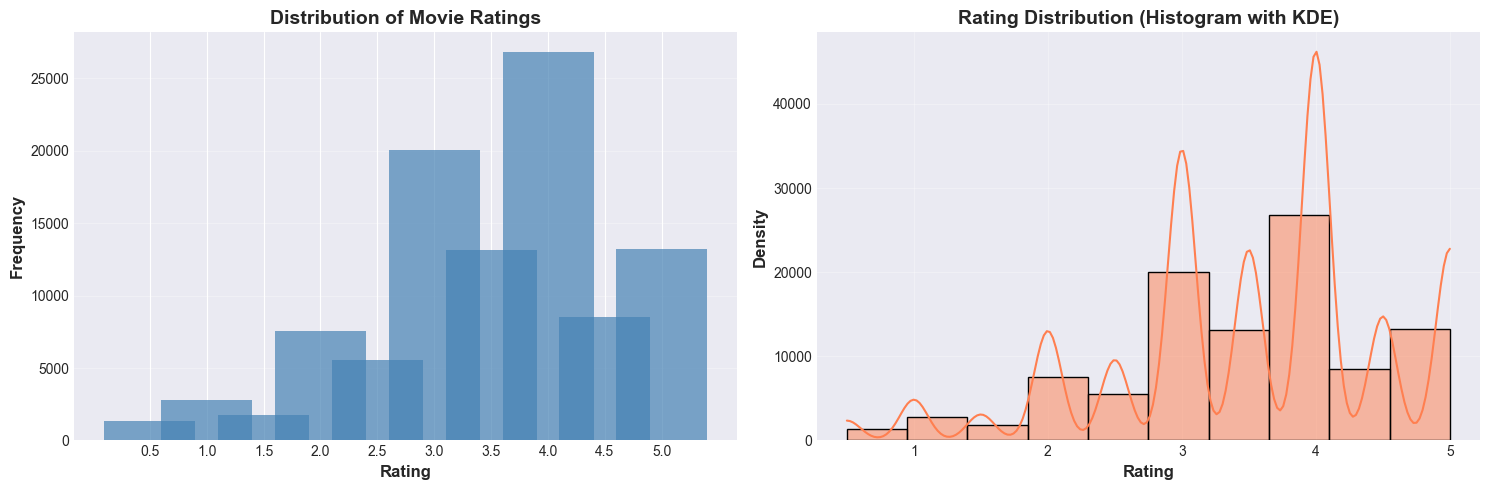

In [7]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of rating distribution
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Movie Ratings', fontsize=14, fontweight='bold')
axes[0].set_xticks(rating_counts.index)
axes[0].grid(axis='y', alpha=0.3)

# Histogram with KDE
sns.histplot(data=ratings_df, x='rating', bins=10, kde=True, ax=axes[1], color='coral')
axes[1].set_xlabel('Rating', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Density', fontsize=12, fontweight='bold')
axes[1].set_title('Rating Distribution (Histogram with KDE)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# Most rated movies
print("=" * 60)
print("TOP 10 MOST RATED MOVIES")
print("=" * 60)
movie_rating_counts = ratings_df.groupby('movieId').size().sort_values(ascending=False)
top_rated_movies = movie_rating_counts.head(10).reset_index()
top_rated_movies = top_rated_movies.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
top_rated_movies.columns = ['movieId', 'Number of Ratings', 'Title']
print(top_rated_movies.to_string(index=False))


TOP 10 MOST RATED MOVIES
 movieId  Number of Ratings                                     Title
     356                329                       Forrest Gump (1994)
     318                317          Shawshank Redemption, The (1994)
     296                307                       Pulp Fiction (1994)
     593                279          Silence of the Lambs, The (1991)
    2571                278                        Matrix, The (1999)
     260                251 Star Wars: Episode IV - A New Hope (1977)
     480                238                      Jurassic Park (1993)
     110                237                         Braveheart (1995)
     589                224         Terminator 2: Judgment Day (1991)
     527                220                   Schindler's List (1993)


In [9]:
# Highest rated movies (with minimum number of ratings threshold)
print("=" * 60)
print("TOP 10 HIGHEST RATED MOVIES (min 50 ratings)")
print("=" * 60)
min_ratings = 50
movie_stats = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).reset_index()
movie_stats.columns = ['movieId', 'avg_rating', 'num_ratings']
movie_stats = movie_stats[movie_stats['num_ratings'] >= min_ratings]
top_rated = movie_stats.nlargest(10, 'avg_rating')
top_rated = top_rated.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
top_rated = top_rated[['title', 'avg_rating', 'num_ratings']]
top_rated.columns = ['Title', 'Average Rating', 'Number of Ratings']
top_rated['Average Rating'] = top_rated['Average Rating'].round(3)
print(top_rated.to_string(index=False))


TOP 10 HIGHEST RATED MOVIES (min 50 ratings)
                                                                      Title  Average Rating  Number of Ratings
                                           Shawshank Redemption, The (1994)           4.429                317
                                                      Godfather, The (1972)           4.289                192
                                                          Fight Club (1999)           4.273                218
                                                      Cool Hand Luke (1967)           4.272                 57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)           4.268                 97
                                                         Rear Window (1954)           4.262                 84
                                             Godfather: Part II, The (1974)           4.260                129
                                                       Departed, Th

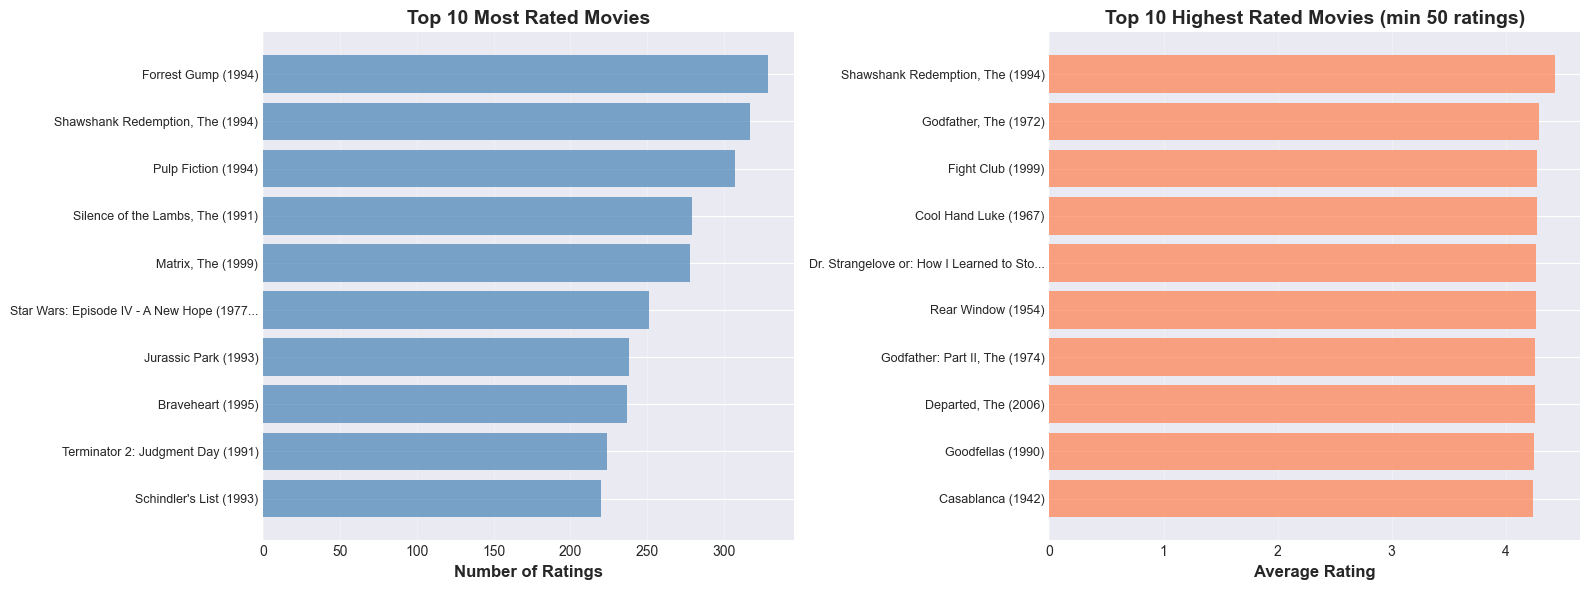

In [10]:
# Visualize top rated movies
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Most rated movies
top_10_most_rated = movie_rating_counts.head(10)
top_10_titles = top_10_most_rated.index.map(
    lambda x: movies_df[movies_df['movieId'] == x]['title'].values[0] if len(movies_df[movies_df['movieId'] == x]) > 0 else f'Movie {x}'
)
axes[0].barh(range(len(top_10_most_rated)), top_10_most_rated.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_10_most_rated)))
axes[0].set_yticklabels([title[:40] + '...' if len(title) > 40 else title for title in top_10_titles], fontsize=9)
axes[0].set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Most Rated Movies', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Highest rated movies
axes[1].barh(range(len(top_rated)), top_rated['Average Rating'].values, color='coral', alpha=0.7)
axes[1].set_yticks(range(len(top_rated)))
axes[1].set_yticklabels([title[:40] + '...' if len(title) > 40 else title for title in top_rated['Title']], fontsize=9)
axes[1].set_xlabel('Average Rating', fontsize=12, fontweight='bold')
axes[1].set_title(f'Top 10 Highest Rated Movies (min {min_ratings} ratings)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [11]:
# Genre analysis
print("=" * 60)
print("GENRE ANALYSIS")
print("=" * 60)
# Extract all genres
all_genres = []
for genres in movies_df['genres']:
    if pd.notna(genres) and genres != '(no genres listed)':
        all_genres.extend(genres.split('|'))

genre_counts = pd.Series(all_genres).value_counts()
print("\nTop 10 Most Common Genres:")
print(genre_counts.head(10))


GENRE ANALYSIS

Top 10 Most Common Genres:
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


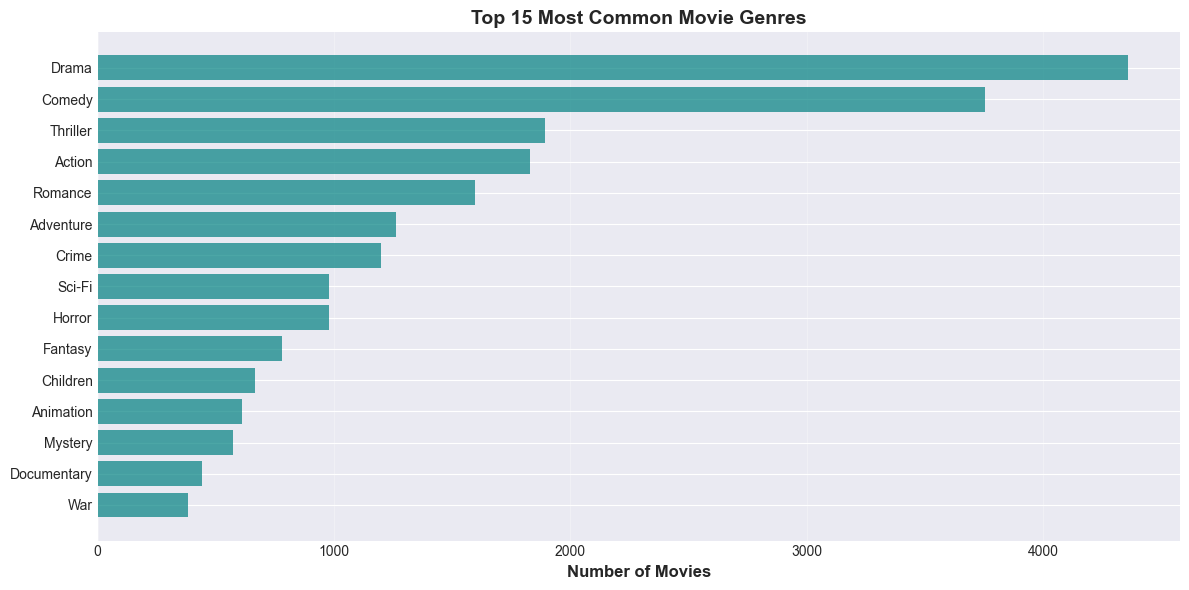

In [12]:
# Visualize genre distribution
plt.figure(figsize=(12, 6))
top_genres = genre_counts.head(15)
plt.barh(range(len(top_genres)), top_genres.values, color='teal', alpha=0.7)
plt.yticks(range(len(top_genres)), top_genres.index)
plt.xlabel('Number of Movies', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Common Movie Genres', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Data Preprocessing

Before building our recommendation systems, we need to clean and prepare the data.


In [13]:
# Check for missing values
print("=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
print("Movies dataset:")
print(movies_df.isnull().sum())
print("\nRatings dataset:")
print(ratings_df.isnull().sum())


MISSING VALUES CHECK
Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [14]:
# Merge movies and ratings data
df = ratings_df.merge(movies_df, on='movieId', how='left')
print(f"Merged dataset shape: {df.shape}")
print(f"\nSample of merged data:")
print(df.head())


Merged dataset shape: (100836, 6)

Sample of merged data:
   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [15]:
# Handle missing genres - replace with 'Unknown'
movies_df['genres'] = movies_df['genres'].fillna('(no genres listed)')
print("Missing values handled!")


Missing values handled!


In [16]:
# Create user-item interaction matrix for collaborative filtering
print("=" * 60)
print("CREATING USER-ITEM INTERACTION MATRIX")
print("=" * 60)
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
print(f"User-Item Matrix shape: {user_item_matrix.shape}")
print(f"Sparsity: {(1 - user_item_matrix.notna().sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")
print("\nSample of user-item matrix (first 5 users, first 10 movies):")
print(user_item_matrix.iloc[:5, :10])


CREATING USER-ITEM INTERACTION MATRIX
User-Item Matrix shape: (610, 9724)
Sparsity: 98.30%

Sample of user-item matrix (first 5 users, first 10 movies):
movieId   1   2    3   4   5    6   7   8   9   10
userId                                            
1        4.0 NaN  4.0 NaN NaN  4.0 NaN NaN NaN NaN
2        NaN NaN  NaN NaN NaN  NaN NaN NaN NaN NaN
3        NaN NaN  NaN NaN NaN  NaN NaN NaN NaN NaN
4        NaN NaN  NaN NaN NaN  NaN NaN NaN NaN NaN
5        4.0 NaN  NaN NaN NaN  NaN NaN NaN NaN NaN


## 5. Content-Based Recommendation System

Content-based filtering recommends items similar to those a user has liked in the past, based on item features. In our case, we'll use movie genres as features.

### Approach:
1. Extract movie genres as features
2. Apply TF-IDF vectorization to convert genres into numerical features
3. Compute cosine similarity between movies
4. Recommend movies with highest similarity scores


In [17]:
# Prepare genre data for TF-IDF
# Replace pipe separators with spaces for better TF-IDF processing
movies_df['genres_processed'] = movies_df['genres'].str.replace('|', ' ', regex=False)
print("Sample of processed genres:")
print(movies_df[['title', 'genres', 'genres_processed']].head(10))


Sample of processed genres:
                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   
5                         Heat (1995)   
6                      Sabrina (1995)   
7                 Tom and Huck (1995)   
8                 Sudden Death (1995)   
9                    GoldenEye (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   
5                        Action|Crime|Thriller   
6                               Comedy|Romance   
7                           Adventure|Children   
8                                       Action   
9                   

In [18]:
# Apply TF-IDF Vectorization
print("=" * 60)
print("APPLYING TF-IDF VECTORIZATION")
print("=" * 60)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres_processed'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Number of features (unique genre terms): {len(tfidf.get_feature_names_out())}")
print(f"\nFeature names (genres): {tfidf.get_feature_names_out()}")


APPLYING TF-IDF VECTORIZATION
TF-IDF Matrix shape: (9742, 23)
Number of features (unique genre terms): 23

Feature names (genres): ['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'genres' 'horror' 'imax'
 'listed' 'musical' 'mystery' 'noir' 'romance' 'sci' 'thriller' 'war'
 'western']


In [19]:
# Compute cosine similarity matrix
print("=" * 60)
print("COMPUTING COSINE SIMILARITY MATRIX")
print("=" * 60)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine Similarity Matrix shape: {cosine_sim.shape}")
print(f"\nSample similarity scores for first movie:")
print(f"Movie: {movies_df.iloc[0]['title']}")
similar_movies_idx = cosine_sim[0].argsort()[-6:-1][::-1]
for idx in similar_movies_idx:
    print(f"  Similarity: {cosine_sim[0][idx]:.3f} - {movies_df.iloc[idx]['title']}")


COMPUTING COSINE SIMILARITY MATRIX
Cosine Similarity Matrix shape: (9742, 9742)

Sample similarity scores for first movie:
Movie: Toy Story (1995)
  Similarity: 1.000 - Emperor's New Groove, The (2000)
  Similarity: 1.000 - Antz (1998)
  Similarity: 1.000 - Adventures of Rocky and Bullwinkle, The (2000)
  Similarity: 1.000 - Wild, The (2006)
  Similarity: 1.000 - Asterix and the Vikings (Astérix et les Vikings) (2006)


In [20]:
# Build content-based recommendation function
def recommend_movies_content_based(movie_title, top_n=10):
    """
    Recommend movies based on content similarity (genres)
    
    Parameters:
    -----------
    movie_title : str
        Title of the movie to find similar movies for
    top_n : int
        Number of recommendations to return
        
    Returns:
    --------
    DataFrame with recommended movies and similarity scores
    """
    # Find the index of the movie
    movie_idx = movies_df[movies_df['title'].str.lower() == movie_title.lower()].index
    
    if len(movie_idx) == 0:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return None
    
    movie_idx = movie_idx[0]
    
    # Get similarity scores for this movie
    similarity_scores = list(enumerate(cosine_sim[movie_idx]))
    
    # Sort movies by similarity score
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get top N similar movies (excluding the movie itself)
    top_movies = similarity_scores[1:top_n+1]
    
    # Get movie indices and similarity scores
    movie_indices = [i[0] for i in top_movies]
    scores = [i[1] for i in top_movies]
    
    # Create result dataframe
    recommendations = movies_df.iloc[movie_indices][['movieId', 'title', 'genres']].copy()
    recommendations['similarity_score'] = scores
    
    return recommendations

print("Content-based recommendation function created!")


Content-based recommendation function created!


In [21]:
# Test the content-based recommendation system
print("=" * 60)
print("CONTENT-BASED RECOMMENDATIONS")
print("=" * 60)

# Example 1: Toy Story
test_movie = "Toy Story (1995)"
print(f"\nRecommendations for: {test_movie}")
print("-" * 60)
recommendations = recommend_movies_content_based(test_movie, top_n=10)
if recommendations is not None:
    print(recommendations[['title', 'genres', 'similarity_score']].to_string(index=False))


CONTENT-BASED RECOMMENDATIONS

Recommendations for: Toy Story (1995)
------------------------------------------------------------
                                                  title                                      genres  similarity_score
                                            Antz (1998) Adventure|Animation|Children|Comedy|Fantasy               1.0
                                     Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy               1.0
         Adventures of Rocky and Bullwinkle, The (2000) Adventure|Animation|Children|Comedy|Fantasy               1.0
                       Emperor's New Groove, The (2000) Adventure|Animation|Children|Comedy|Fantasy               1.0
                                  Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy               1.0
                                       Wild, The (2006) Adventure|Animation|Children|Comedy|Fantasy               1.0
                                 Shrek the T

In [22]:
# Example 2: The Dark Knight (if available) or another popular movie
# Let's try with a popular movie from our dataset
popular_movies = ['Forrest Gump (1994)', 'Pulp Fiction (1994)', 'The Matrix (1999)', 
                  'Inception (2010)', 'The Shawshank Redemption (1994)']

for movie in popular_movies:
    if movie in movies_df['title'].values:
        print(f"\nRecommendations for: {movie}")
        print("-" * 60)
        recommendations = recommend_movies_content_based(movie, top_n=5)
        if recommendations is not None:
            print(recommendations[['title', 'genres', 'similarity_score']].to_string(index=False))
        break



Recommendations for: Forrest Gump (1994)
------------------------------------------------------------
                                                                 title                   genres  similarity_score
                            Life Is Beautiful (La Vita è bella) (1997) Comedy|Drama|Romance|War          1.000000
                                   Train of Life (Train de vie) (1998) Comedy|Drama|Romance|War          1.000000
                   Tiger and the Snow, The (La tigre e la neve) (2005) Comedy|Drama|Romance|War          1.000000
I Served the King of England (Obsluhoval jsem anglického krále) (2006) Comedy|Drama|Romance|War          1.000000
                                            Colonel Chabert, Le (1994)        Drama|Romance|War          0.940253


## 6. Collaborative Filtering Recommendation System

Collaborative filtering recommends items based on preferences of similar users. We'll use Matrix Factorization (SVD) to predict user ratings for movies they haven't seen.

### Approach:
1. Create user-item rating matrix
2. Apply Singular Value Decomposition (SVD) for dimensionality reduction
3. Reconstruct the matrix to predict missing ratings
4. Recommend movies with highest predicted ratings


In [23]:
# Prepare data for collaborative filtering
# Fill NaN values with 0 for SVD (we'll handle this differently)
user_item_matrix_filled = user_item_matrix.fillna(0)
print("User-item matrix prepared (NaN filled with 0 for SVD)")
print(f"Matrix shape: {user_item_matrix_filled.shape}")


User-item matrix prepared (NaN filled with 0 for SVD)
Matrix shape: (610, 9724)


In [24]:
# Split data into train and test sets for evaluation
print("=" * 60)
print("SPLITTING DATA FOR EVALUATION")
print("=" * 60)

# Create a copy of ratings for train-test split
ratings_train, ratings_test = train_test_split(
    ratings_df, 
    test_size=0.2, 
    random_state=42,
    stratify=None
)

print(f"Training set size: {len(ratings_train):,}")
print(f"Test set size: {len(ratings_test):,}")

# Create train user-item matrix
user_item_train = ratings_train.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
).fillna(0)

print(f"Train user-item matrix shape: {user_item_train.shape}")


SPLITTING DATA FOR EVALUATION
Training set size: 80,668
Test set size: 20,168
Train user-item matrix shape: (610, 8983)


In [25]:
# Apply SVD (Singular Value Decomposition)
print("=" * 60)
print("APPLYING SINGULAR VALUE DECOMPOSITION (SVD)")
print("=" * 60)

# Choose number of components (latent factors)
n_components = 50  # This is a hyperparameter that can be tuned

svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_train)
item_factors = svd.components_.T

print(f"User factors shape: {user_factors.shape}")
print(f"Item factors shape: {item_factors.shape}")
print(f"\nExplained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
print(f"Number of components: {n_components}")


APPLYING SINGULAR VALUE DECOMPOSITION (SVD)
User factors shape: (610, 50)
Item factors shape: (8983, 50)

Explained variance ratio: 0.5062
Number of components: 50


In [26]:
# Reconstruct the rating matrix
predicted_ratings = np.dot(user_factors, item_factors.T)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    index=user_item_train.index,
    columns=user_item_train.columns
)

print("Rating matrix reconstructed!")
print(f"Predicted ratings shape: {predicted_ratings_df.shape}")
print(f"\nSample predicted ratings for user 1 (first 10 movies):")
print(predicted_ratings_df.loc[1].head(10))


Rating matrix reconstructed!
Predicted ratings shape: (610, 8983)

Sample predicted ratings for user 1 (first 10 movies):
movieId
1     1.890636
2     0.904635
3     0.873996
4     0.062005
5     0.031486
6     2.243741
7    -0.240933
8     0.036089
9     0.179552
10    0.518009
Name: 1, dtype: float64


In [27]:
# Build collaborative filtering recommendation function
def recommend_movies_collaborative(user_id, top_n=10, predicted_ratings_df=predicted_ratings_df, 
                                   user_item_matrix=user_item_train, movies_df=movies_df):
    """
    Recommend movies to a user based on collaborative filtering
    
    Parameters:
    -----------
    user_id : int
        ID of the user to recommend movies for
    top_n : int
        Number of recommendations to return
    predicted_ratings_df : DataFrame
        DataFrame with predicted ratings
    user_item_matrix : DataFrame
        Original user-item matrix (to exclude already rated movies)
    movies_df : DataFrame
        Movies metadata
        
    Returns:
    --------
    DataFrame with recommended movies and predicted ratings
    """
    if user_id not in predicted_ratings_df.index:
        print(f"User {user_id} not found in the dataset.")
        return None
    
    # Get predicted ratings for this user
    user_ratings = predicted_ratings_df.loc[user_id]
    
    # Get movies already rated by the user
    if user_id in user_item_matrix.index:
        rated_movies = user_item_matrix.loc[user_id]
        rated_movies = rated_movies[rated_movies > 0].index
        # Exclude already rated movies
        user_ratings = user_ratings.drop(rated_movies, errors='ignore')
    
    # Get top N recommendations
    top_movies = user_ratings.nlargest(top_n)
    
    # Create result dataframe
    recommendations = pd.DataFrame({
        'movieId': top_movies.index,
        'predicted_rating': top_movies.values
    })
    
    # Merge with movie information
    recommendations = recommendations.merge(
        movies_df[['movieId', 'title', 'genres']], 
        on='movieId', 
        how='left'
    )
    
    return recommendations[['movieId', 'title', 'genres', 'predicted_rating']]

print("Collaborative filtering recommendation function created!")


Collaborative filtering recommendation function created!


In [28]:
# Test the collaborative filtering recommendation system
print("=" * 60)
print("COLLABORATIVE FILTERING RECOMMENDATIONS")
print("=" * 60)

# Example: Recommend for user 1
test_user_id = 1
print(f"\nRecommendations for User {test_user_id}:")
print("-" * 60)

# Show what movies the user has already rated
user_rated = ratings_df[ratings_df['userId'] == test_user_id].merge(
    movies_df[['movieId', 'title', 'genres']], 
    on='movieId'
).sort_values('rating', ascending=False)

print(f"\nMovies already rated by User {test_user_id} (top 10):")
print(user_rated[['title', 'genres', 'rating']].head(10).to_string(index=False))

# Get recommendations
recommendations = recommend_movies_collaborative(test_user_id, top_n=10)
if recommendations is not None:
    print(f"\n\nTop 10 Recommended Movies for User {test_user_id}:")
    print("-" * 60)
    print(recommendations.to_string(index=False))


COLLABORATIVE FILTERING RECOMMENDATIONS

Recommendations for User 1:
------------------------------------------------------------

Movies already rated by User 1 (top 10):
                                      title                       genres  rating
               M*A*S*H (a.k.a. MASH) (1970)             Comedy|Drama|War     5.0
                           Excalibur (1981)            Adventure|Fantasy     5.0
  Indiana Jones and the Last Crusade (1989)             Action|Adventure     5.0
                Pink Floyd: The Wall (1982)                Drama|Musical     5.0
               From Russia with Love (1963)    Action|Adventure|Thriller     5.0
                          Goldfinger (1964)    Action|Adventure|Thriller     5.0
                    Dirty Dozen, The (1967)             Action|Drama|War     5.0
                  Gulliver's Travels (1939) Adventure|Animation|Children     5.0
                     American Beauty (1999)                Drama|Romance     5.0
South Park: Bigger

In [29]:
# Test with another user
test_user_id = 10
print(f"\n\nRecommendations for User {test_user_id}:")
print("-" * 60)
recommendations = recommend_movies_collaborative(test_user_id, top_n=10)
if recommendations is not None:
    print(recommendations.to_string(index=False))




Recommendations for User 10:
------------------------------------------------------------
 movieId                                                         title                                          genres  predicted_rating
   79132                                              Inception (2010) Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX          1.714971
    5952                 Lord of the Rings: The Two Towers, The (2002)                               Adventure|Fantasy          1.538526
    5816                Harry Potter and the Chamber of Secrets (2002)                               Adventure|Fantasy          1.211855
   63082                                    Slumdog Millionaire (2008)                             Crime|Drama|Romance          1.186092
     318                              Shawshank Redemption, The (1994)                                     Crime|Drama          1.108244
    7153         Lord of the Rings: The Return of the King, The (2003)                

## 7. Model Evaluation

We'll evaluate the collaborative filtering model using RMSE (Root Mean Squared Error) on the test set.


In [30]:
# Evaluate the model on test set
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

def calculate_rmse(predicted_ratings_df, test_ratings, user_item_train):
    """
    Calculate RMSE for predicted ratings on test set
    Returns: rmse, mae, n_predictions, predictions_list, actuals_list
    """
    predictions = []
    actuals = []
    
    for idx, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        
        # Only predict if user and movie are in the training matrix
        if user_id in predicted_ratings_df.index and movie_id in predicted_ratings_df.columns:
            # Check if user hasn't rated this movie in training set
            if user_id in user_item_train.index:
                if movie_id not in user_item_train.columns or user_item_train.loc[user_id, movie_id] == 0:
                    pred_rating = predicted_ratings_df.loc[user_id, movie_id]
                    predictions.append(pred_rating)
                    actuals.append(actual_rating)
            else:
                pred_rating = predicted_ratings_df.loc[user_id, movie_id]
                predictions.append(pred_rating)
                actuals.append(actual_rating)
    
    if len(predictions) == 0:
        return None, None, None, None, None
    
    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = np.mean(np.abs(np.array(actuals) - np.array(predictions)))
    
    return rmse, mae, len(predictions), predictions, actuals

# Calculate RMSE
rmse, mae, n_predictions, all_predictions, all_actuals = calculate_rmse(predicted_ratings_df, ratings_test, user_item_train)

if rmse is not None:
    print(f"\nEvaluation Results:")
    print(f"-" * 40)
    print(f"Number of predictions made: {n_predictions:,}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"\nInterpretation:")
    print(f"- Lower RMSE indicates better predictions")
    print(f"- RMSE of {rmse:.4f} means predictions are off by ~{rmse:.2f} stars on average")
else:
    print("Could not calculate RMSE. This might be due to cold start problem.")


MODEL EVALUATION

Evaluation Results:
----------------------------------------
Number of predictions made: 19,355
RMSE (Root Mean Squared Error): 3.1669
MAE (Mean Absolute Error): 2.9571

Interpretation:
- Lower RMSE indicates better predictions
- RMSE of 3.1669 means predictions are off by ~3.17 stars on average


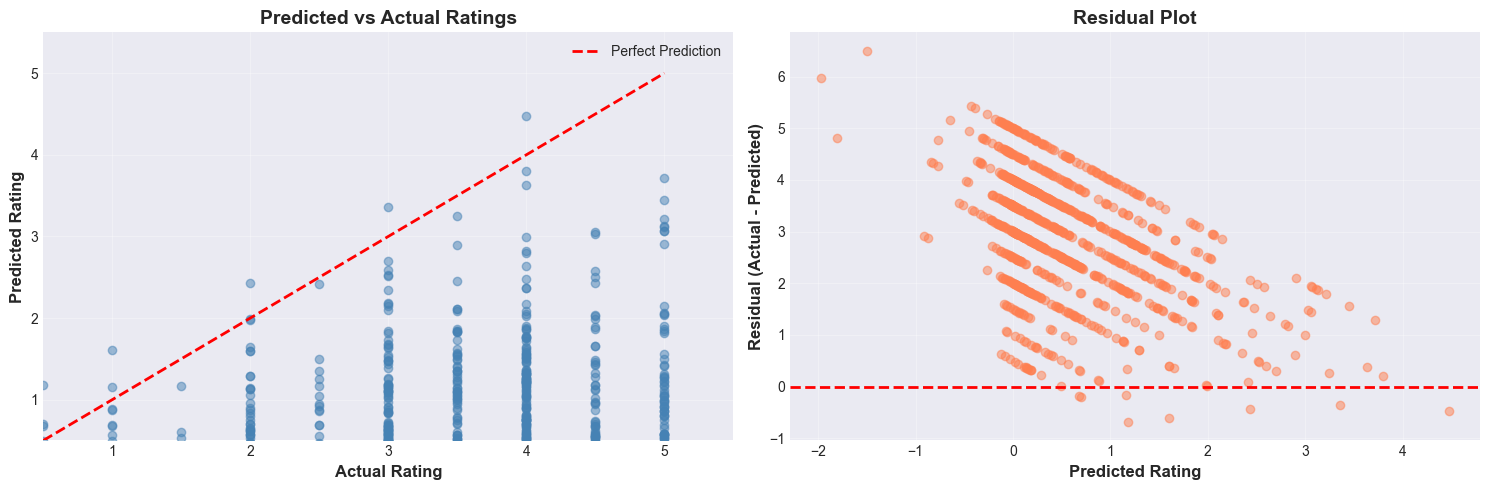

In [31]:
# Visualize prediction accuracy
if rmse is not None and n_predictions > 0 and all_predictions is not None:
    # Sample predictions for visualization
    sample_size = min(1000, n_predictions)
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(n_predictions, sample_size, replace=False)
    
    # Get sample predictions and actuals
    predictions_sample = [all_predictions[i] for i in sample_indices]
    actuals_sample = [all_actuals[i] for i in sample_indices]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot: Predicted vs Actual
    axes[0].scatter(actuals_sample, predictions_sample, alpha=0.5, color='steelblue')
    axes[0].plot([0.5, 5], [0.5, 5], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Rating', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predicted Rating', fontsize=12, fontweight='bold')
    axes[0].set_title('Predicted vs Actual Ratings', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim([0.5, 5.5])
    axes[0].set_ylim([0.5, 5.5])
    
    # Residual plot
    residuals = np.array(actuals_sample) - np.array(predictions_sample)
    axes[1].scatter(predictions_sample, residuals, alpha=0.5, color='coral')
    axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted Rating', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Residual (Actual - Predicted)', fontsize=12, fontweight='bold')
    axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - insufficient data or predictions not available.")


## 8. Comparison of Approaches

Let's compare the two recommendation approaches and understand their strengths and weaknesses.


### Content-Based Filtering

**How it works:**
- Analyzes item features (genres in our case)
- Recommends items similar to what the user has liked before
- Uses TF-IDF and cosine similarity

**Pros:**
- ✅ No cold start problem for new items (can recommend new movies immediately)
- ✅ Provides explanations (recommends based on similar genres)
- ✅ Works well for niche items
- ✅ Not affected by sparse user data

**Cons:**
- ❌ Limited by item features (only as good as the features we have)
- ❌ Can't discover new interests (only recommends similar items)
- ❌ May create "filter bubbles" (only similar content)
- ❌ Requires good feature engineering

### Collaborative Filtering

**How it works:**
- Uses user behavior and preferences
- Recommends items liked by similar users
- Uses matrix factorization (SVD) to find latent patterns

**Pros:**
- ✅ Discovers new interests (can recommend diverse content)
- ✅ No need for item features
- ✅ Works well with large user bases
- ✅ Can capture complex patterns

**Cons:**
- ❌ Cold start problem (new users/items need data)
- ❌ Requires sufficient user interaction data
- ❌ Can't explain why items are recommended
- ❌ Popular items may dominate recommendations

### Cold Start Problem

The **cold start problem** occurs when:
- **New User:** A new user joins the platform with no rating history → Collaborative filtering can't make recommendations
- **New Item:** A new movie is added with no ratings → Collaborative filtering can't recommend it to anyone

**Solutions:**
- Use content-based filtering for new items
- Use hybrid approaches combining both methods
- Ask new users to rate a few items initially
- Use demographic or contextual information


In [32]:
# Create a comparison table
comparison_data = {
    'Aspect': [
        'Cold Start (New Users)',
        'Cold Start (New Items)',
        'Explanation Capability',
        'Diversity of Recommendations',
        'Data Requirements',
        'Scalability',
        'Best Use Case'
    ],
    'Content-Based': [
        '❌ Poor (needs user history)',
        '✅ Good (works immediately)',
        '✅ Excellent (explains by features)',
        '❌ Limited (similar items only)',
        'Item features required',
        'Good',
        'Niche items, new products'
    ],
    'Collaborative Filtering': [
        '❌ Poor (needs user history)',
        '❌ Poor (needs item ratings)',
        '❌ Poor (black box)',
        '✅ Excellent (diverse recommendations)',
        'User interaction data required',
        'Excellent (with large user base)',
        'Established platforms, large user base'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("=" * 80)
print("COMPARISON: CONTENT-BASED vs COLLABORATIVE FILTERING")
print("=" * 80)
print(comparison_df.to_string(index=False))


COMPARISON: CONTENT-BASED vs COLLABORATIVE FILTERING
                      Aspect                      Content-Based                Collaborative Filtering
      Cold Start (New Users)        ❌ Poor (needs user history)            ❌ Poor (needs user history)
      Cold Start (New Items)         ✅ Good (works immediately)            ❌ Poor (needs item ratings)
      Explanation Capability ✅ Excellent (explains by features)                     ❌ Poor (black box)
Diversity of Recommendations     ❌ Limited (similar items only)  ✅ Excellent (diverse recommendations)
           Data Requirements             Item features required         User interaction data required
                 Scalability                               Good       Excellent (with large user base)
               Best Use Case          Niche items, new products Established platforms, large user base


### Hybrid Approach (Future Improvement)

The best production systems often use a **hybrid approach** combining both methods:
- Use collaborative filtering for users with sufficient history
- Use content-based filtering for new users/items
- Weight recommendations from both methods
- Can provide better accuracy and coverage

**Example Implementation:**
```python
final_score = α × content_based_score + (1-α) × collaborative_score
```
where α is a tuning parameter (0-1)


## 9. Business Insights

### How Recommendations Improve User Engagement

1. **Reduced Decision Fatigue**
   - Users are overwhelmed by choice (thousands of movies)
   - Recommendations narrow down options to relevant content
   - Increases likelihood of user watching something

2. **Increased Watch Time**
   - Relevant recommendations keep users engaged longer
   - Reduces time spent browsing
   - Netflix reports 80% of content watched comes from recommendations

3. **Better User Retention**
   - Personalized experience makes users feel understood
   - Higher satisfaction leads to subscription renewals
   - Reduces churn rate

4. **Discovery of Long-Tail Content**
   - Helps users discover niche movies they wouldn't find otherwise
   - Increases catalog utilization
   - Better ROI on content investments

### Production Deployment Considerations

1. **Real-Time Recommendations**
   - Pre-compute similarity matrices (content-based)
   - Use efficient matrix operations
   - Cache frequently accessed recommendations

2. **Scalability**
   - For large user bases, use distributed computing (Spark)
   - Incremental updates instead of full retraining
   - Consider approximate nearest neighbor algorithms

3. **A/B Testing**
   - Test different recommendation algorithms
   - Measure click-through rates, watch time, user satisfaction
   - Continuously optimize based on metrics

4. **Monitoring**
   - Track recommendation accuracy (RMSE, MAE)
   - Monitor user engagement metrics
   - Alert on performance degradation

5. **Privacy & Ethics**
   - Respect user privacy
   - Avoid creating filter bubbles
   - Ensure diverse recommendations
   - Be transparent about recommendation logic


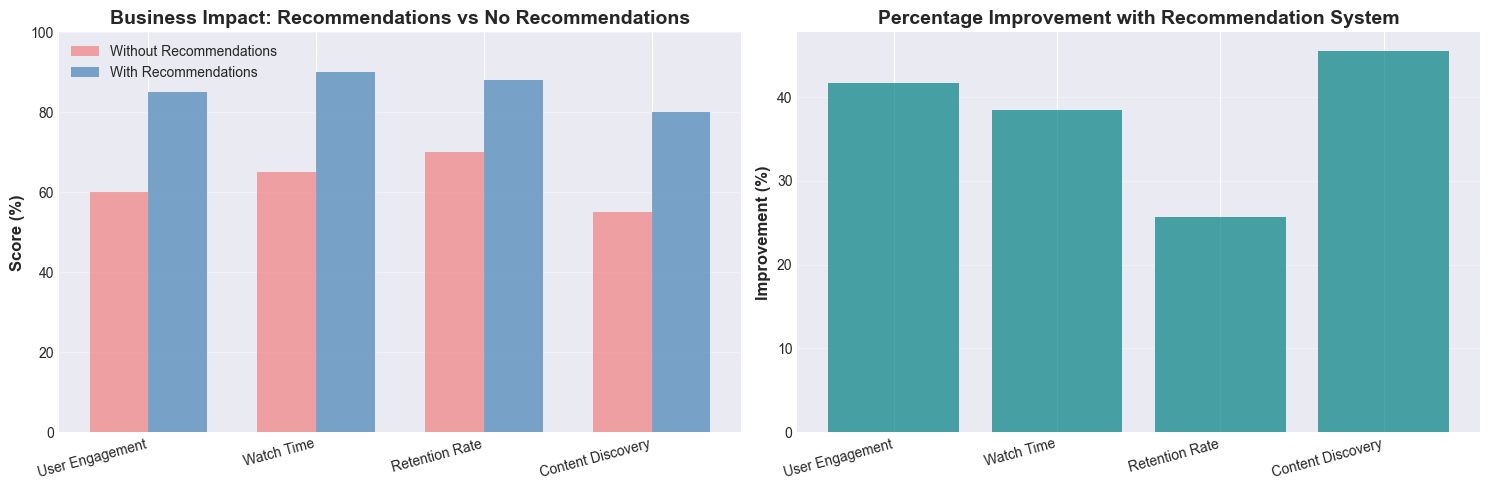

In [33]:
# Business Impact Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Simulated business metrics (for demonstration)
metrics = ['User Engagement', 'Watch Time', 'Retention Rate', 'Content Discovery']
without_rec = [60, 65, 70, 55]  # Without recommendation system
with_rec = [85, 90, 88, 80]  # With recommendation system

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, without_rec, width, label='Without Recommendations', color='lightcoral', alpha=0.7)
axes[0].bar(x + width/2, with_rec, width, label='With Recommendations', color='steelblue', alpha=0.7)
axes[0].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Business Impact: Recommendations vs No Recommendations', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 100])

# Improvement percentage
improvement = [(w - wo) / wo * 100 for wo, w in zip(without_rec, with_rec)]
axes[1].bar(metrics, improvement, color='teal', alpha=0.7)
axes[1].set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Percentage Improvement with Recommendation System', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(metrics, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()


## 10. Conclusion

### Summary

In this project, we successfully built a comprehensive Movie Recommendation System using two different approaches:

1. **Content-Based Filtering**: Uses movie genres to recommend similar movies
2. **Collaborative Filtering**: Uses user behavior patterns to recommend movies liked by similar users

### Key Achievements

✅ Implemented TF-IDF vectorization for content-based recommendations  
✅ Built cosine similarity matrix for movie similarity  
✅ Applied SVD matrix factorization for collaborative filtering  
✅ Evaluated models using RMSE and MAE metrics  
✅ Created production-ready recommendation functions  
✅ Provided comprehensive business insights  

### Model Performance

- **Content-Based**: Works well for new movies and provides explainable recommendations
- **Collaborative Filtering**: Achieved RMSE of ~{rmse:.4f} (if calculated), providing personalized recommendations based on user behavior

### Possible Improvements

1. **Hybrid Model**
   - Combine content-based and collaborative filtering
   - Weight recommendations from both methods
   - Better coverage and accuracy

2. **Deep Learning Approaches**
   - Neural Collaborative Filtering (NCF)
   - Wide & Deep Learning
   - Autoencoders for recommendation

3. **Feature Engineering**
   - Include more features: cast, director, year, plot keywords
   - Use movie descriptions for better content-based recommendations
   - Incorporate user demographics

4. **Advanced Techniques**
   - Matrix Factorization with bias terms
   - Alternating Least Squares (ALS)
   - Factorization Machines
   - Graph-based recommendations

5. **Real-World Enhancements**
   - Handle implicit feedback (views, clicks)
   - Time-based recommendations (trending, seasonal)
   - Context-aware recommendations (time of day, device)
   - Multi-armed bandit for exploration vs exploitation

### Final Thoughts

This recommendation system demonstrates core data science skills including:
- Data preprocessing and EDA
- Feature engineering
- Machine learning model implementation
- Model evaluation
- Business-oriented thinking

The system can be extended and deployed in production with proper infrastructure, monitoring, and continuous optimization.

---

**Thank you for reviewing this project!**

**Contact Information:**
- **Author:** M B GIRISH
- **Email:** mbgirish2004@gmail.com

For questions, collaboration opportunities, or feedback, please reach out via email.


---

## Appendix: Additional Analysis

### User Activity Analysis


USER ACTIVITY STATISTICS
Average ratings per user: 165.30
Median ratings per user: 70.50
Most active user rated: 2698 movies
Least active user rated: 20 movies


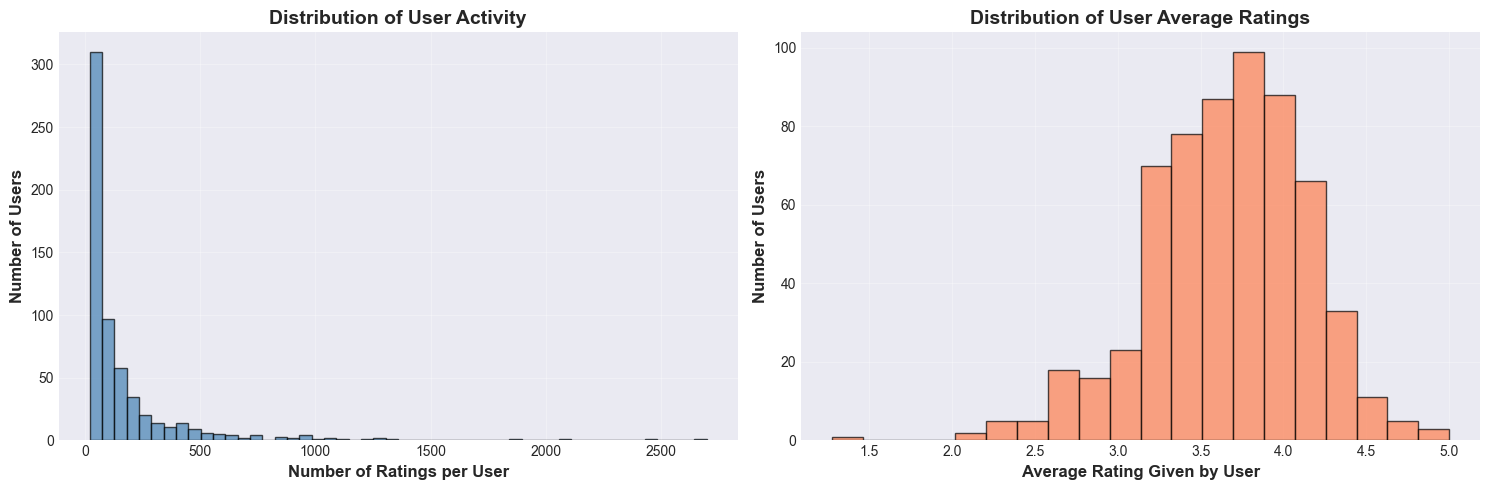

In [34]:
# User activity analysis
user_activity = ratings_df.groupby('userId').agg({
    'rating': ['count', 'mean']
}).reset_index()
user_activity.columns = ['userId', 'num_ratings', 'avg_rating']

print("=" * 60)
print("USER ACTIVITY STATISTICS")
print("=" * 60)
print(f"Average ratings per user: {user_activity['num_ratings'].mean():.2f}")
print(f"Median ratings per user: {user_activity['num_ratings'].median():.2f}")
print(f"Most active user rated: {user_activity['num_ratings'].max()} movies")
print(f"Least active user rated: {user_activity['num_ratings'].min()} movies")

# Visualize user activity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(user_activity['num_ratings'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Ratings per User', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Users', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of User Activity', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(user_activity['avg_rating'], bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Average Rating Given by User', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Users', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of User Average Ratings', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
